In [1]:
import torch # to create tensors to store the raw data, weights and biases 
import torch.nn as nn # to make the weights and biases learnable (part of the network)
import torch.nn.functional as F # to apply activation functions 
from torch.optim import Adam  
from torch.distributions.uniform import Uniform

import lightning as L # to train the model 
from torch.utils.data import DataLoader, TensorDataset # to load the data 
from lightning.pytorch.tuner.tuning import Tuner      
from lightning.pytorch.callbacks import ModelCheckpoint #Lightning is trying to delete the previous checkpoint (because the default ModelCheckpoint is set to save_top_k=1).
                                                        # On Windows a file gets locked as soon as any program (Explorer preview, antivirus, TensorBoard, VS Code, …) opens it, and Windows then blocks the delete call ⇒ PermissionError WinError 32

import pandas as pd # to load the data 

import matplotlib.pyplot as plt # graphs 
import seaborn as sns # graphs


C:\Users\dell\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
inputs= torch.tensor([[1.,0.,0.,0.],
                    [0.,1.,0.,0.],
                    [0.,0.,1.,0.],
                    [0.,0.,0.,1.]])
labels= torch.tensor([[0.,1.,0.,0.], 
                    [0.,0.,1.,0.],
                    [0.,0.,0.,1.],
                    [0.,1.,0.,0.]])

dataset= TensorDataset(inputs,labels)
dataloader= DataLoader(dataset)

In [3]:
class WordEmbeddingFromScratch(L.LightningModule):
    def __init__(self):
        super().__init__()

        min_value=-0.5
        max_value=0.5

        self.input1_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input1_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input2_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input2_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input3_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input3_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input4_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input4_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.output1_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output1_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output2_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output2_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output3_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output3_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output4_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output4_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.loss= nn.CrossEntropyLoss() # we don't need to calc the softmax function because the nn.CrossEntropyLoss() does it for us

    def forward(self, input):
        input= input[0] # to remove the set of [] from the input list we get from the list 

        input_to_top_hidden = ((input[0] * self.input1_w1) +(input[1] * self.input2_w1) +(input[2] * self.input3_w1) +(input[3] * self.input4_w1))

        input_to_bottom_hidden = ((input[0] * self.input1_w2) +(input[1] * self.input2_w2) +(input[2] * self.input3_w2) +(input[3] * self.input4_w2))

        output1= (input_to_top_hidden * self.output1_w1) +(input_to_bottom_hidden * self.output1_w2)

        output2= (input_to_top_hidden * self.output2_w1) +(input_to_bottom_hidden * self.output2_w2)

        output3= (input_to_top_hidden * self.output3_w1) +(input_to_bottom_hidden * self.output3_w2)

        output4= (input_to_top_hidden * self.output4_w1) +(input_to_bottom_hidden * self.output4_w2)

        output_presoftmax = torch.stack([output1, output2, output3, output4]) # we use torch.stack to preserve the gradients of the output

        return output_presoftmax

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.1)

    def training_step(self, batch, batch_idx):
        input_i,label_i = batch
        output_i=self.forward(input_i)
        loss=self.loss(output_i, label_i[0])
        return loss



In [4]:
modelFromScratch=WordEmbeddingFromScratch()

print("before optimization, the parameters are:")
for name,param in modelFromScratch.named_parameters():
    print(name, param.data)

before optimization, the parameters are:
input1_w1 tensor(-0.3194)
input1_w2 tensor(0.0347)
input2_w1 tensor(0.1496)
input2_w2 tensor(0.3925)
input3_w1 tensor(-0.4431)
input3_w2 tensor(0.2767)
input4_w1 tensor(-0.2875)
input4_w2 tensor(-0.0632)
output1_w1 tensor(-0.1481)
output1_w2 tensor(0.2966)
output2_w1 tensor(-0.1608)
output2_w2 tensor(0.4397)
output3_w1 tensor(-0.0400)
output3_w2 tensor(0.4560)
output4_w1 tensor(0.3073)
output4_w2 tensor(-0.1381)


In [5]:
data = {
    "w1": [modelFromScratch.input1_w1.item(),
           modelFromScratch.input2_w1.item(),
           modelFromScratch.input3_w1.item(),
           modelFromScratch.input4_w1.item()],
    "w2": [modelFromScratch.input1_w2.item(),
           modelFromScratch.input2_w2.item(),
           modelFromScratch.input3_w2.item(),
           modelFromScratch.input4_w2.item()],
    "token": ["DL", "is", "great", "easy"],
    "input": ["input1", "input2", "input3", "input4"]
}

df = pd.DataFrame(data)
df

,w1,w2,token,input
0,-0.319434,0.034701,DL,input1
1,0.149603,0.392512,is,input2
2,-0.443101,0.276712,great,input3
3,-0.287473,-0.063181,easy,input4


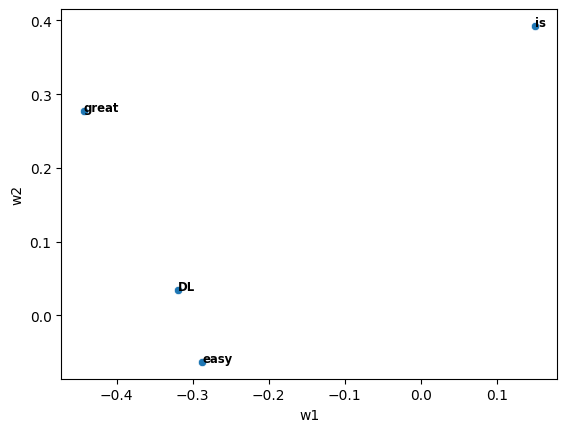

In [6]:
sns.scatterplot(data=df, x="w1", y="w2")
plt.text(df.w1[0], df.w2[0], df.token[0], horizontalalignment="left",color="black",size='small',weight='semibold')
plt.text(df.w1[1], df.w2[1], df.token[1], horizontalalignment="left",color="black",size='small',weight='semibold')
plt.text(df.w1[2], df.w2[2], df.token[2], horizontalalignment="left",color="black",size='small',weight='semibold')
plt.text(df.w1[3], df.w2[3], df.token[3], horizontalalignment="left",color="black",size='small',weight='semibold')

plt.show()

In [7]:
ckpt_cb = ModelCheckpoint(save_top_k=-1)   # -1 = keep everything

trainer=L.Trainer(max_epochs=100,callbacks=[ckpt_cb])
trainer.fit(modelFromScratch, train_dataloaders=dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\dell\AppData\Roaming\Python\Python313\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\dell\AppData\Roaming\Python\Python313\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\dell\AppData\Roaming\Python\Python313\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one maj

Epoch 99: 100%|██████████| 4/4 [00:00<00:00, 219.45it/s, v_num=97]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 4/4 [00:00<00:00, 157.37it/s, v_num=97]


In [10]:
data = {
    "w1": [modelFromScratch.input1_w1.item(),
           modelFromScratch.input2_w1.item(),
           modelFromScratch.input3_w1.item(),
           modelFromScratch.input4_w1.item()],
    "w2": [modelFromScratch.input1_w2.item(),
           modelFromScratch.input2_w2.item(),
           modelFromScratch.input3_w2.item(),
           modelFromScratch.input4_w2.item()],
    "token": ["DL", "is", "great", "easy"],
    "input": ["input1", "input2", "input3", "input4"]
}

df = pd.DataFrame(data)
df


,w1,w2,token,input
0,-1.982407,1.604618,DL,input1
1,2.057652,2.212308,is,input2
2,-0.458040,-2.421249,great,input3
3,-1.884405,1.474362,easy,input4


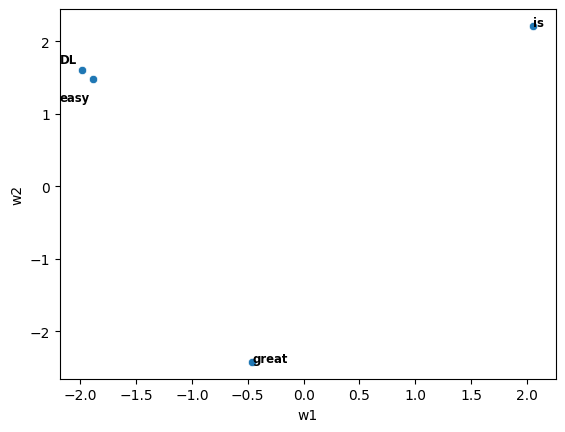

In [11]:
sns.scatterplot(data=df, x="w1", y="w2")
plt.text(df.w1[0]-0.2, df.w2[0]+0.1, df.token[0], horizontalalignment="left",color="black",size='small',weight='semibold')
plt.text(df.w1[1], df.w2[1], df.token[1], horizontalalignment="left",color="black",size='small',weight='semibold')
plt.text(df.w1[2], df.w2[2], df.token[2], horizontalalignment="left",color="black",size='small',weight='semibold')
plt.text(df.w1[3]-0.3, df.w2[3]-0.3, df.token[3], horizontalalignment="left",color="black",size='small',weight='semibold')

plt.show()

In [12]:
softmax = nn.Softmax(dim=0)#dim=0 means along the rows, 1 is for columns

print(torch.round(softmax(modelFromScratch(torch.tensor([[1., 0., 0., 0.]]))),decimals=2))

print(torch.round(softmax(modelFromScratch(torch.tensor([[0., 1., 0., 0.]]))),decimals=2))

print(torch.round(softmax(modelFromScratch(torch.tensor([[0., 0., 1., 0.]]))),decimals=2))

print(torch.round(softmax(modelFromScratch(torch.tensor([[0., 0., 0., 1.]]))),decimals=2))


tensor([0., 1., 0., 0.], grad_fn=<RoundBackward1>)
tensor([0., 0., 1., 0.], grad_fn=<RoundBackward1>)
tensor([0., 0., 0., 1.], grad_fn=<RoundBackward1>)
tensor([0., 1., 0., 0.], grad_fn=<RoundBackward1>)


In [21]:
class WordEmbeddingWithLinear(L.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.input_to_hidden = nn.Linear(in_features=4, out_features=2,bias=False) # 4 input features (weights) and 2 hidden features (nodes)
        self.hidden_to_output = nn.Linear(in_features=2, out_features=4,bias=False) # 2 hidden features (weights) and 4 output features (nodes)
        
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, input): # we don't need to remove the brackets [] from the input list cuz linear don't care
        hidden = self.input_to_hidden(input)
        output_values = self.hidden_to_output(hidden)
        return (output_values)
    
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.1)

    def training_step(self, batch, batch_idx):
        input_i,label_i = batch
        output_i=self.forward(input_i)
        loss=self.loss(output_i, label_i)
        
        return loss

In [29]:
modelLinear = WordEmbeddingWithLinear()

data = {
"w1": modelLinear.input_to_hidden.weight.detach()[0].numpy(),
"w2": modelLinear.input_to_hidden.weight.detach()[1].numpy(),
"token": ["DL", "is", "great", "easy"],
"input": ["input1", "input2", "input3", "input4"]
}

df = pd.DataFrame(data)
df

,w1,w2,token,input
0,0.131029,0.435956,DL,input1
1,0.434041,-0.323687,is,input2
2,-0.329702,-0.050545,great,input3
3,-0.254588,-0.351857,easy,input4


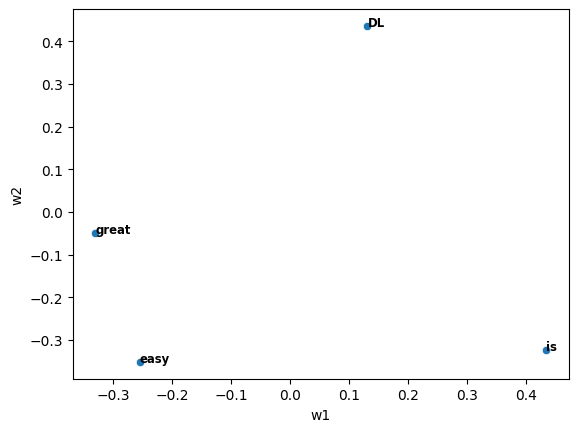

In [30]:
sns.scatterplot(data=df, x="w1", y="w2")
plt.text(df.w1[0], df.w2[0], df.token[0], horizontalalignment="left",color="black",size='small',weight='semibold')
plt.text(df.w1[1], df.w2[1], df.token[1], horizontalalignment="left",color="black",size='small',weight='semibold')
plt.text(df.w1[2], df.w2[2], df.token[2], horizontalalignment="left",color="black",size='small',weight='semibold')
plt.text(df.w1[3], df.w2[3], df.token[3], horizontalalignment="left",color="black",size='small',weight='semibold')

plt.show()

In [31]:
ckpt_cb = ModelCheckpoint(save_top_k=-1)   # -1 = keep everything

trainer=L.Trainer(max_epochs=100,callbacks=[ckpt_cb])
trainer.fit(modelLinear, train_dataloaders=dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | input_to_hidden  | Linear           | 8      | train
1 | hidden_to_output | Linear           | 8      | train
2 | loss             | CrossEntropyLoss | 0      | train
--------------------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
C:\Users\dell\AppData\Roaming\Python\Python313\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
C:\Users\dell\AppD

Epoch 99: 100%|██████████| 4/4 [00:00<00:00, 240.61it/s, v_num=101]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 4/4 [00:00<00:00, 183.30it/s, v_num=101]


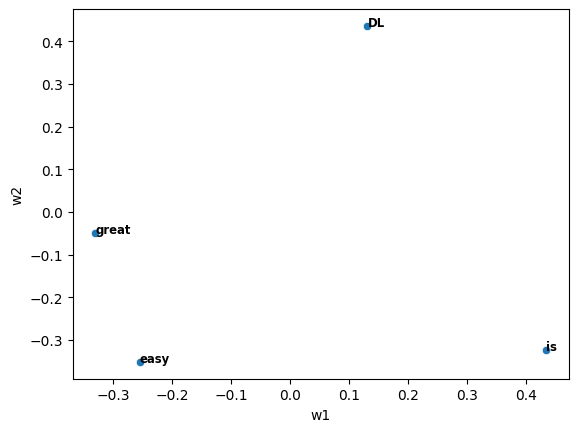

In [32]:
sns.scatterplot(data=df, x="w1", y="w2")
plt.text(df.w1[0], df.w2[0], df.token[0], horizontalalignment="left",color="black",size='small',weight='semibold')
plt.text(df.w1[1], df.w2[1], df.token[1], horizontalalignment="left",color="black",size='small',weight='semibold')
plt.text(df.w1[2], df.w2[2], df.token[2], horizontalalignment="left",color="black",size='small',weight='semibold')
plt.text(df.w1[3], df.w2[3], df.token[3], horizontalalignment="left",color="black",size='small',weight='semibold')

plt.show()